# API Demo and Testing
Notebook to demonstrate API use case and unit testing.

In [ ]:
import requests
import random
#!pip install matplotlib
import matplotlib.pyplot as plt

In [6]:
# Define MODELS global variable for testing
with open('api/resources/accepted_models.txt') as f:
    MODELS = [line.strip() for line in f.readlines()]

In [7]:
# Define URL
#url = 'http://127.0.0.1:5000/' # -> USE THIS TO TEST LOCAL APPLICATION
url = 'http://127.0.0.1:8080/'  # -> USE THIS TO TEST DOCKER IMAGE

### /inference

**POST**: Performs mask inference with given string against a HuggingFace model. Returns a list of JSON objects containing a probability score, a token string (value to fill in [MASK]), and the original string with [MASK] replaced.


In [8]:
#### Test 1: Payloads

# Define payload list
payloads = [
    {'model': 'bert-base-uncased'},    # Expecting 500; 'input' not found in payload
    {'input': "Hello I'm a [MASK] model.", 'model': 'not-a-model'}, # Expecting 500; not a valid 'model'
    {'input': "Hello I'm a model.", 'model': 'bert-base-uncased'}, # Expecting 500; 'input' must contain [MASK] or <mask> token
    {'input': "Hello I'm a [MASK] model.", 'model': 'bert-base-uncased'}, # Expecting 201; valid payload
    {'input': "Hello I'm a <mask> model.", 'model': 'bert-base-uncased'}, # Expecting 201; valid payload (<mask> converted to [MASK])
    {'input': "Hello I'm a <mask> model.", 'model': 'roberta-base'}, # Expecting 201; valid payload
    {'input': "Hello I'm a [MASK] model.", 'model': 'roberta-base'}, # Expecting 201; valid payload ([MASK] converted to <mask>)
    {'input': "Hello I'm a [MASK] model."} # Expecting 201; defaults to 'bert-base-uncased'
]

# Define expected status codes
true_status = [500, 500, 500, 201, 201, 201, 201]

# Run tests
for p, s in list(zip(payloads, true_status)):
    # POST request
    res = requests.post(url + 'inference', json = p)

    # Assert truth
    assert res.status_code == s

    # Print json output
    print(p, ':')
    print('\t', res.json())
    print()
    print()

{'model': 'bert-base-uncased'} :
	 {'message': 'ValueError: input string is required.'}


{'input': "Hello I'm a [MASK] model.", 'model': 'not-a-model'} :
	 {'message': "ValueError: model is not accepted. Please select from the following: ['bert-base-uncased', 'distilbert-base-uncased', 'roberta-base', 'roberta-large', 'xlm-roberta-base']."}


{'input': "Hello I'm a model.", 'model': 'bert-base-uncased'} :
	 {'message': 'ValueError: input must contain [MASK] or <mask> tokens.'}


{'input': "Hello I'm a [MASK] model.", 'model': 'bert-base-uncased'} :
	 {'data': [{'score': 0.10731087625026703, 'token': 4827, 'token_str': 'fashion', 'sequence': "hello i'm a fashion model."}, {'score': 0.08774493634700775, 'token': 2535, 'token_str': 'role', 'sequence': "hello i'm a role model."}, {'score': 0.05338375270366669, 'token': 2047, 'token_str': 'new', 'sequence': "hello i'm a new model."}, {'score': 0.046672236174345016, 'token': 3565, 'token_str': 'super', 'sequence': "hello i'm a super model."

bert-base-uncased :
	 {'data': [{'score': 0.10731087625026703, 'token': 4827, 'token_str': 'fashion', 'sequence': "hello i'm a fashion model."}, {'score': 0.08774493634700775, 'token': 2535, 'token_str': 'role', 'sequence': "hello i'm a role model."}, {'score': 0.05338375270366669, 'token': 2047, 'token_str': 'new', 'sequence': "hello i'm a new model."}, {'score': 0.046672236174345016, 'token': 3565, 'token_str': 'super', 'sequence': "hello i'm a super model."}, {'score': 0.027095822617411613, 'token': 2986, 'token_str': 'fine', 'sequence': "hello i'm a fine model."}], 'inference_time': 0.16192}


distilbert-base-uncased :
	 {'data': [{'score': 0.052928581833839417, 'token': 2535, 'token_str': 'role', 'sequence': "hello i'm a role model."}, {'score': 0.03968587517738342, 'token': 4827, 'token_str': 'fashion', 'sequence': "hello i'm a fashion model."}, {'score': 0.03474365547299385, 'token': 2449, 'token_str': 'business', 'sequence': "hello i'm a business model."}, {'score': 0.034623004

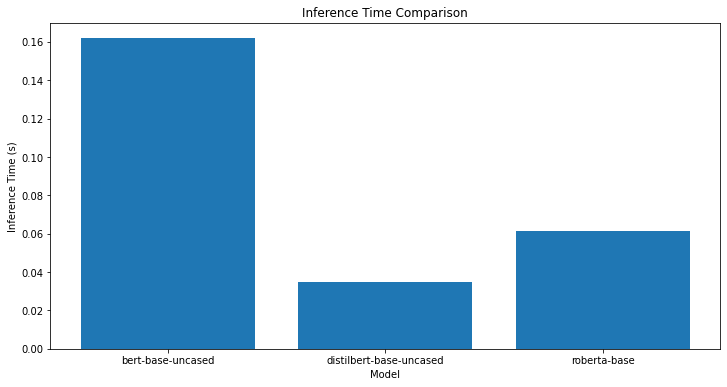

In [12]:
#### Test 2: Checking model output + 'inference_time' chart (example use case of response)

# Define universal payload object
payload = {'input': "Hello I'm a [MASK] model."}

# Run tests
inf_time = dict()

for m in MODELS:
    if m != 'roberta-large':  # Experienced some connection issues
        try:
            # Update payload
            payload['model'] = m

            # Post request
            res = requests.post(url + 'inference', json = payload)

            # Assert truth
            assert res.status_code == 201

            # Collect inference time
            inf_time[m] = res.json()['inference_time']

            # Print json output
            print(m, ':')
            print('\t', res.json())
            print()
            print()
        except:
            print(m, 'not available at the moment.')

# Compare inference times between models
plt.figure(figsize=(12,6))
plt.bar(range(len(inf_time)), list(inf_time.values()), tick_label=list(inf_time.keys()))
plt.title('Inference Time Comparison')
plt.xlabel('Model')
plt.ylabel('Inference Time (s)')
plt.show()


In [16]:
#### Test 3: Checking other random strings for inference output

# Define 'random' input 
rand_input = ['[MASK] are my favorite animals!', 'Did you see <mask> at the store?', 'This is a very long string. It is being tested to see what the [MASK] should be. Hopefully it works!']

# Define 'random' models
rand_models = random.sample(['bert-base-uncased', 'distilbert-base-uncased', 'roberta-base'], len(rand_input)) # Connection ssues with roberta-large and xlm-roberta-base

# Run tests
for i, m in list(zip(rand_input, rand_models)):
    # Define payload object
    payload = {'input': i, 'model': m}

    # POST request
    res = requests.post(url + 'inference', json = payload)

    # Assert truth
    assert res.status_code == 201

    # Print json output
    print(i, '+', m, ':')
    print('\t', res.json())
    print()
    print()

[MASK] are my favorite animals! + distilbert-base-uncased :
	 {'data': [{'score': 0.5758854746818542, 'token': 2122, 'token_str': 'these', 'sequence': 'these are my favorite animals!'}, {'score': 0.044400956481695175, 'token': 2027, 'token_str': 'they', 'sequence': 'they are my favorite animals!'}, {'score': 0.027573466300964355, 'token': 8870, 'token_str': 'cats', 'sequence': 'cats are my favorite animals!'}, {'score': 0.025463862344622612, 'token': 2017, 'token_str': 'you', 'sequence': 'you are my favorite animals!'}, {'score': 0.025326590985059738, 'token': 2057, 'token_str': 'we', 'sequence': 'we are my favorite animals!'}], 'inference_time': 0.13513}


Did you see <mask> at the store? + roberta-base :
	 {'data': [{'score': 0.3986685872077942, 'token': 123, 'token_str': ' him', 'sequence': 'Did you see him at the store?'}, {'score': 0.13045206665992737, 'token': 106, 'token_str': ' them', 'sequence': 'Did you see them at the store?'}, {'score': 0.06444765627384186, 'token': 1268, '

### /inference/models

**GET**: Lists the HuggingFace inference models (formatted as expected in the POST payload) currently supported by the API, as outlined in **api/resources/accepted_models.txt**.

In [17]:
# Test 1: inference/models endpoint with GET request
res = requests.get(url + 'inference/models')

# Assert truth
assert res.status_code == 200

# Print JSON response
print('Response:', res.json())

# Compare against models
print()
print('Models List:', MODELS)

Response: {'models': ['bert-base-uncased', 'distilbert-base-uncased', 'roberta-base', 'roberta-large', 'xlm-roberta-base']}

Models List: ['bert-base-uncased', 'distilbert-base-uncased', 'roberta-base', 'roberta-large', 'xlm-roberta-base']


### /healthcheck

**GET**: Basic check to see if API is functioning. Returns a HTTP 200.
(Also supports **HEAD** request.)

In [18]:
#### Test 1: Validating healthcheck output

# GET request
get_res = requests.get(url + 'healthcheck')
assert get_res.status_code == 200
print(get_res.json())

# HEAD request
head_res = requests.head(url + 'healthcheck')
assert head_res.status_code == 200

HEALTHY


### /healthcheck/extracheck

**GET**: Extra check to see if HuggingFace models download page is functioning. Returns a HTTP 200 if healthy and HTTP 404 if unhealthy. (Also supports **HEAD** request.)

In [19]:
#### Test 1: Validating healthcheck/extracheck output

# GET request
get_res = requests.get(url + 'healthcheck/extracheck')
assert get_res.status_code == 200
print(get_res.json())

# HEAD request
head_res = requests.head(url + 'healthcheck/extracheck')
assert head_res.status_code == 200

HEALTHY
